In [33]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import autograd.numpy as np
from autograd import grad

In [12]:
SBM = nx.stochastic_block_model([100,100], [[0.25,0.03],[0.03,0.25]], seed=5)

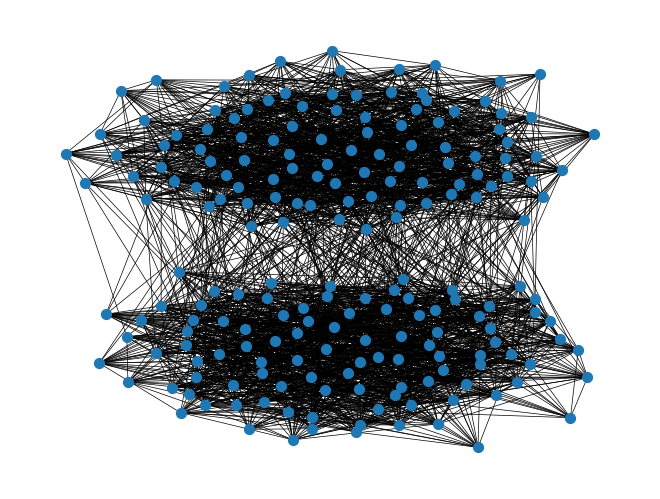

In [19]:
nx.draw(SBM,pos=nx.spring_layout(SBM),node_size=50,width=0.5)

In [17]:
# nodes from block 1
first_block_nodes = np.arange(0,100)
second_block_nodes = np.arange(100,200)

In [21]:
# Generate innate opinion
block_1_innate = 1 - np.random.rand(100)
block_2_innate = -np.random.rand(100)

In [23]:
 total_innate = np.concatenate((block_1_innate, block_2_innate))

In [28]:
for tup in SBM.edges():
    u, v = sorted(tup)
    if u < 100 and v >= 100:
        SBM[u][v]['weight'] = np.random.uniform(-1, 1)
    else:
        SBM[u][v]['weight'] = np.random.uniform(0, 1)

In [31]:
# Gradient
def f(L):
    I = np.eye(L.shape[0])
    return np.dot(total_innate.T, np.linalg.inv(I + L)) @ total_innate
#     return np.inverse(A + np.identity(len(A)))

grad_f = grad(f)

In [157]:
# Projection
def projection(L, budget, L_0):
    modified_L = np.zeros((len(L), len(L)))
    newly_added_idx_val = dict()

    for i in range(0, len(L_0)):
        for j in range(len(L_0)):
            if i == j:
                continue
            elif L_0[i,j] != 0:
                modified_L[i,j] = L_0[i,j]
            elif L_0[i,j] == 0 and L[i,j] != 0:
                pair = tuple(sorted((i,j)))
                if (pair in newly_added_idx_val and L[i,j] > newly_added_idx_val[pair]) or (pair not in newly_added_idx_val):
                    newly_added_idx_val[pair] = L[i,j]
                    
    sorted_keys = sorted(newly_added_idx_val, key=newly_added_idx_val.get,reverse=True)[:budget]
#     print(newly_added_idx_val[sorted_keys[0]])
    for key in sorted_keys:
        i,j = key
        modified_L[i,j] = newly_added_idx_val[key]
        modified_L[j,i] = newly_added_idx_val[key]
    max_val = np.max(np.abs(modified_L))
#     print(L_0[0])
#     print(modified_L[0])
#     print(np.sum(modified_L[0]))
    for i in range(len(modified_L)):
        modified_L[i,i] = -np.sum(modified_L[i])
    return modified_L

In [158]:
def conflict(L, innate_opinion):
    I = np.eye(L.shape[0])
    return np.dot(innate_opinion.T, np.linalg.inv(I + L)) @ innate_opinion
    
def grad_descent(L, eta, innate_opinion, budget, num_iter, threshold, grad_f):
    L_0 = L
    L_k = L
    step = [conflict(L_0,innate_opinion)]
    for k in range(num_iter):
        L_k = L_k - eta * grad_f(L_k)
        L_k = projection(L_k, budget, L_0)
        step.append(conflict(L_k,innate_opinion))
    return step, L_k

In [159]:
SBM_L = nx.laplacian_matrix(SBM).toarray()

In [164]:
eta = 0.1
budget = 100
num_iter = 50

step, L_k = grad_descent(SBM_L, eta, total_innate, budget, num_iter, 0.00001, grad_f)

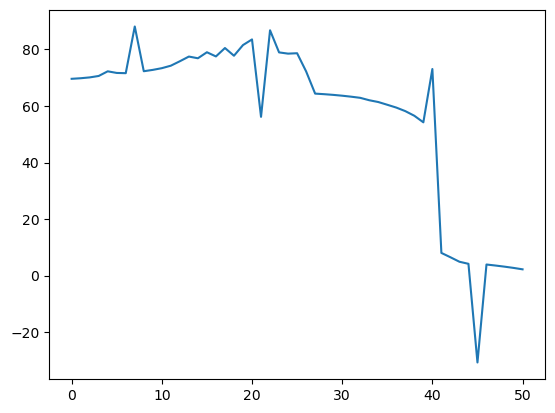

In [166]:
X = np.arange(0, 51)
plt.plot(X, step)

In [151]:
L_k

array([[13.86528233,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  6.65178708, -0.52411867, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.52411867, 12.95391044, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 11.29357888,
        -0.29461941, -0.31832858],
       [ 0.        ,  0.        ,  0.        , ..., -0.29461941,
        14.92626976,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.31832858,
         0.        , 12.7670792 ]])

In [124]:
L_k

array([[-13.86528233,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -6.65178708,  -0.52411867, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -0.52411867, -12.95391044, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., -11.29357888,
         -0.29461941,  -0.31832858],
       [  0.        ,   0.        ,   0.        , ...,  -0.29461941,
        -14.92626976,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,  -0.31832858,
          0.        , -12.7670792 ]])

In [92]:
step

[69.61714841171815,
 -4.3131647431518765,
 -4.313166113328314,
 -4.313167486412792,
 -4.313168862406047,
 -4.313170241308816,
 -4.313171623121843,
 -4.313173007845862,
 -4.313174395481625,
 -4.31317578602987,
 -4.313177179491342]